# **Problem Statement:**

In the era of information overload, distinguishing between genuine news and fake news has become increasingly challenging. Fake news can have significant negative impacts on society, such as spreading misinformation, inciting panic, influencing public opinion, and even affecting democratic processes. Therefore, it is crucial to develop effective methods to automatically identify and filter out fake news from real news.

# **Objective:**

The objective of this machine learning project is to develop a robust model that can accurately classify news articles as either real or fake. By leveraging natural language processing (NLP) techniques and machine learning algorithms, the project aims to build a system that predicts the authenticity of news and improves detection accuracy.

# **About the Dataset:**

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
           1: Fake News
           0: Real News





# Load the libraries

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from wordcloud import STOPWORDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import optuna
from optuna import Trial
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
filepath = "/content/drive/My Drive/Fake_news.csv"
df = pd.read_csv(filepath)

# Looking into the dataset

In [ ]:
df.shape

(20800, 5)

In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
df.nunique()

id        20800
title     19803
author     4201
text      20386
label         2
dtype: int64

# Handling Missing Values

## Fill missing values in 'title' with an empty string

In [ ]:
df['title'].fillna('', inplace=True)

## Fill missing values in 'author' with 'Unknown'

In [ ]:
df['author'].fillna('Unknown', inplace=True)

## Drop rows with missing 'text'

In [ ]:
df.dropna(subset=['text'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20761 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20761 non-null  int64 
 1   title   20761 non-null  object
 2   author  20761 non-null  object
 3   text    20761 non-null  object
 4   label   20761 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 973.2+ KB


In [ ]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
df.nunique()

id        20761
title     19765
author     4202
text      20386
label         2
dtype: int64

# Exploratory  Data Analysis

In [ ]:
df['label'].value_counts()

label
0    10387
1    10374
Name: count, dtype: int64

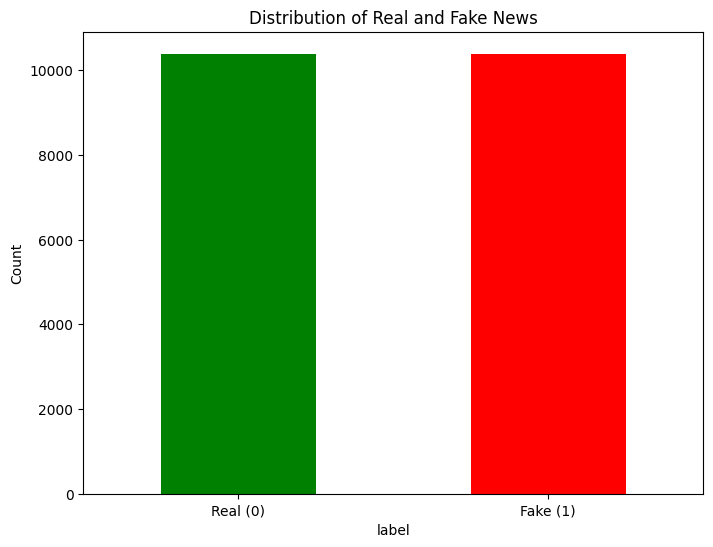

In [ ]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Real and Fake News')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Real (0)', 'Fake (1)'], rotation=0)
plt.show()

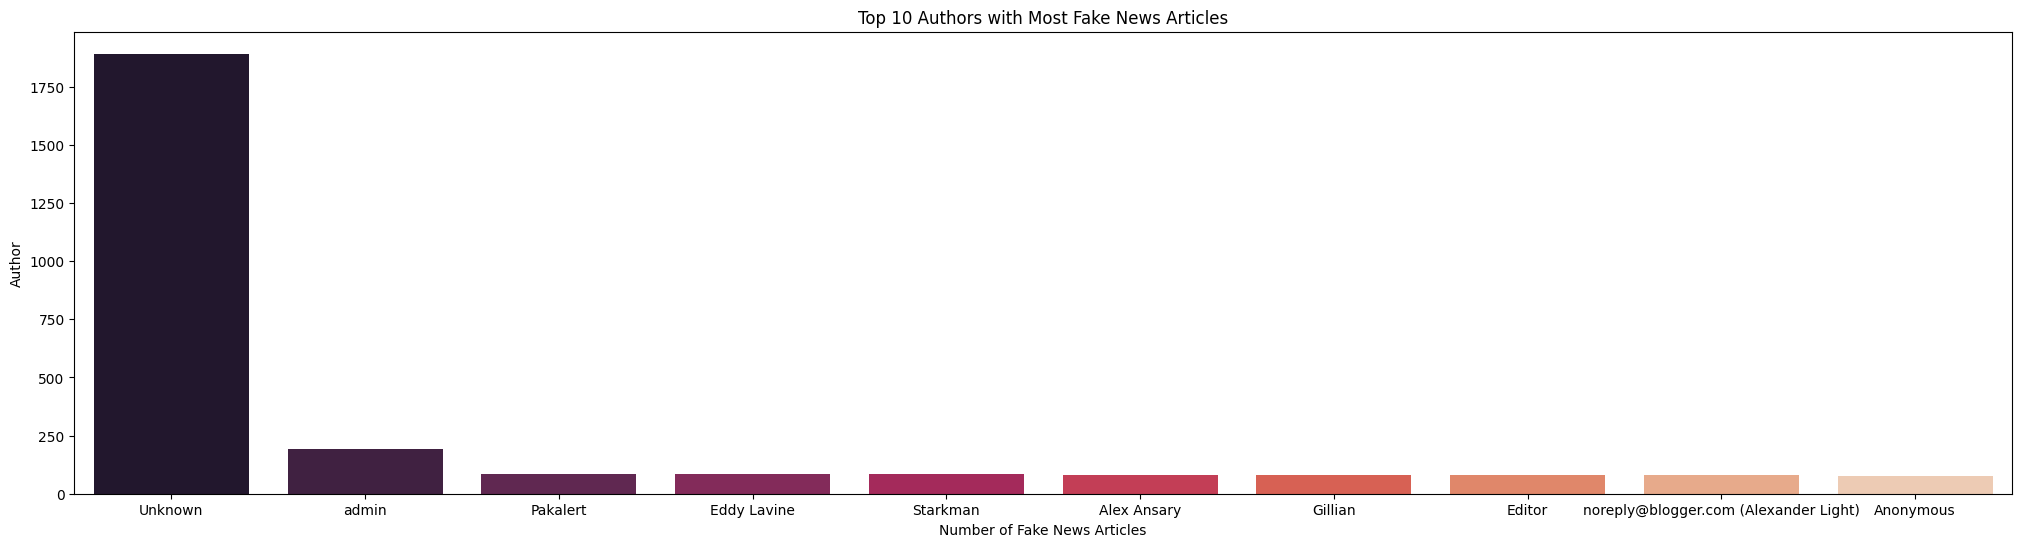

In [ ]:
author_counts = df[df['label'] == 1]['author'].value_counts().head(10)
author_counts_df = pd.DataFrame({'author': author_counts.index, 'count': author_counts.values})

plt.figure(figsize=(25, 6))
sns.barplot(x='author', y='count', data=author_counts_df, palette='rocket')
plt.title('Top 10 Authors with Most Fake News Articles')
plt.xlabel('Number of Fake News Articles')
plt.ylabel('Author')
plt.show()

# Feature Engineering

## Combine 'title', 'author', and 'text' for feature extraction

In [ ]:
df['combined_text'] = df['title'] + ' ' + df['author'] + ' ' + df['text']

In [ ]:
df.head()

,id,title,author,text,label,combined_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


## Drop the all the columns except label	and combined_text

In [ ]:
df.drop(columns=['id', 'title', 'author', 'text'], inplace= True)

In [ ]:
df.head()

,label,combined_text
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,1,Why the Truth Might Get You Fired Consortiumne...
3,1,15 Civilians Killed In Single US Airstrike Hav...
4,1,Iranian woman jailed for fictional unpublished...


# Separating the combined_text & label

In [ ]:
X = df.drop(columns='label', axis=1)
y = df['label']

In [ ]:
X

,combined_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...
...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,Macy’s Is Said to Receive Takeover Approach by...
20798,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [ ]:
y

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20761, dtype: int64

# Use Term Frequency - Inverse Document Frequency (TF-IDF) for scoring the text

In [ ]:
tfidf = TfidfVectorizer(token_pattern= "[a-z']+", stop_words=list(STOPWORDS))

In [ ]:
tfidf = tfidf.fit_transform(X.values.ravel())

In [ ]:
tfidf

<20761x151966 sparse matrix of type '<class 'numpy.float64'>'
	with 5686974 stored elements in Compressed Sparse Row format>

# Use SVD to transform the sparse TF-IDF matrix into a dense matrix

In [ ]:
svd= TruncatedSVD(n_components= 500, algorithm= 'arpack')
svd_mat= svd.fit_transform(tfidf)

In [ ]:
svd_mat.shape

(20761, 500)

In [ ]:
svd_mat

array([[ 0.17308462, -0.14076632,  0.09652879, ..., -0.04787032,
         0.00379543, -0.00198135],
       [ 0.21612556, -0.12209764,  0.06890655, ..., -0.02221518,
        -0.01477006, -0.00329278],
       [ 0.21953809, -0.08693545, -0.10815563, ...,  0.02839013,
        -0.00057059,  0.01702326],
       ...,
       [ 0.15564166, -0.00635437, -0.06571009, ...,  0.0043729 ,
        -0.01159098, -0.01086185],
       [ 0.09563832, -0.04178235, -0.08720637, ..., -0.00876759,
        -0.00289891, -0.00729083],
       [ 0.13905753, -0.05536277, -0.08169914, ..., -0.0104361 ,
         0.00401215,  0.03593772]])

# Map the SVD matrix with label and split the dataset into training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(svd_mat, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((16608, 500), (4153, 500))

# Training the model

## Logistic Regression model

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred_test = model.predict(X_test)

### Model Evaluation

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'Logistic Regression - Test Accuracy: {test_accuracy}')
print(f'Logistic Regression - Test Precision: {test_precision}')
print(f'Logistic Regression - Test Recall: {test_recall}')
print(f'Logistic Regression - Test F1-score: {test_f1}')

Logistic Regression - Test Accuracy: 0.9556946785456296
Logistic Regression - Test Precision: 0.9470198675496688
Logistic Regression - Test Recall: 0.9652844744455159
Logistic Regression - Test F1-score: 0.9560649474689589


Text(0.5, 1.05, 'Confusion_matrix')

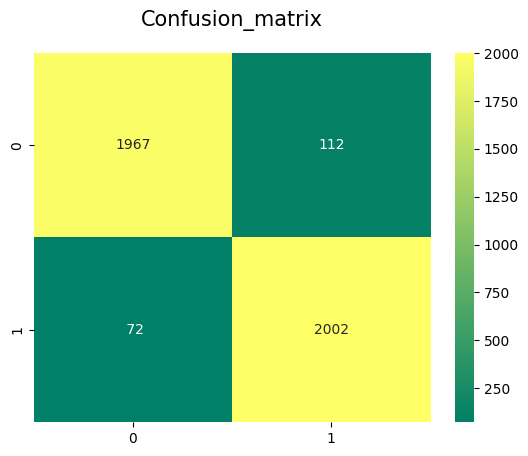

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)



---
### **Test Accuracy: 0.9556946785456296**

---




## Random Forest Classifier model

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
    }

    model = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-07-07 05:54:05,656] A new study created in memory with name: no-name-2fef22e9-f52e-41ad-8e80-815d7d709529
[I 2024-07-07 05:55:02,320] Trial 0 finished with value: 0.9684565456554983 and parameters: {'n_estimators': 200, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9684565456554983.
[I 2024-07-07 05:57:39,458] Trial 1 finished with value: 0.9750740750189376 and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9750740750189376.
[I 2024-07-07 05:58:36,474] Trial 2 finished with value: 0.9657149001339613 and parameters: {'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9750740750189376.
[I 2024-07-07 05:59:19,264] Trial 3 finished with value: 0.9711475502831955 and parameters: {'n_estimators': 60, 'max_depth': 16, 'm

In [ ]:
print(f'Best parameters for Random Forest: {study.best_params}')

Best parameters for Random Forest: {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


In [ ]:
rf_model = RandomForestClassifier(**study.best_params, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [ ]:
y_pred_test = rf_model.predict(X_test)

### Model Evaluation

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'Random Forest - Test Accuracy: {test_accuracy}')
print(f'Random Forest - Test Precision: {test_precision}')
print(f'Random Forest - Test Recall: {test_recall}')
print(f'Random Forest - Test F1-score: {test_f1}')

Random Forest - Test Accuracy: 0.93065254033229
Random Forest - Test Precision: 0.934761441090555
Random Forest - Test Recall: 0.9257473481195757
Random Forest - Test F1-score: 0.9302325581395349


Text(0.5, 1.05, 'Confusion_matrix')

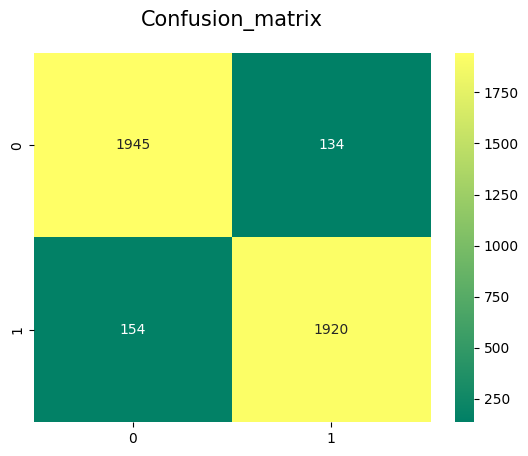

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)



---
### **Test Accuracy: 0.93065254033229**

---




## GradientBoosting Classifier model

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 20, 300, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }

    model = GradientBoostingClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

study_gbm = optuna.create_study(direction='maximize')
study_gbm.optimize(objective, n_trials=30)

[I 2024-07-07 10:25:24,189] A new study created in memory with name: no-name-76baf8c5-f8b9-4ce6-82dc-4f8503161ba6
[I 2024-07-07 10:26:30,969] Trial 0 finished with value: 0.9843314901684482 and parameters: {'learning_rate': 0.16371098679388874, 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 16, 'subsample': 0.7051366790363123, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9843314901684482.
[I 2024-07-07 10:27:47,728] Trial 1 finished with value: 0.984260923733002 and parameters: {'learning_rate': 0.06436017664339008, 'n_estimators': 280, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 16, 'subsample': 0.5954440083661878, 'max_features': 'log2'}. Best is trial 0 with value: 0.9843314901684482.
[I 2024-07-07 10:28:23,782] Trial 2 finished with value: 0.983554129296258 and parameters: {'learning_rate': 0.16881149289774258, 'n_estimators': 260, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 15, 'subsample': 0.597191128

In [ ]:
print(f'Best parameters for GradientBoosting: {study_gbm.best_params}')

Best parameters for GradientBoosting: {'learning_rate': 0.19712588583134838, 'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 20, 'subsample': 0.8256195996551174, 'max_features': 'sqrt'}


In [ ]:
gbm_model = GradientBoostingClassifier(**study_gbm.best_params, random_state=42)
gbm_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.19712588583134838, max_depth=8,
                           max_features='sqrt', min_samples_leaf=20,
                           n_estimators=300, random_state=42,
                           subsample=0.8256195996551174)

In [ ]:
y_pred_test = gbm_model.predict(X_test)

### Model Evaluation

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'GradientBoosting - Test Accuracy: {test_accuracy}')
print(f'GradientBoosting - Test Precision: {test_precision}')
print(f'GradientBoosting - Test Recall: {test_recall}')
print(f'GradientBoosting - Test F1-score: {test_f1}')

GradientBoosting - Test Accuracy: 0.9501565133638333
GradientBoosting - Test Precision: 0.9464371114299378
GradientBoosting - Test Recall: 0.9541947926711668
GradientBoosting - Test F1-score: 0.9503001200480191


Text(0.5, 1.05, 'Confusion_matrix')

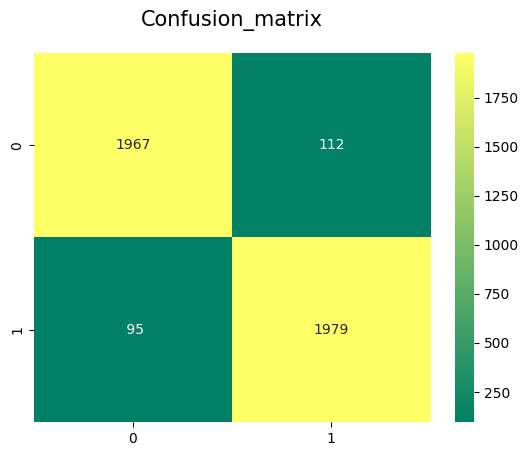

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)



---
### **Test Accuracy: 0.9501565133638333**
---

## XGBoost Classifier model

In [ ]:
def objective(trial):
  params= {
      'learning_rate': trial.suggest_float('learning_rate',0.001,0.2),
      'max_depth': trial.suggest_int('max_depth',1,8),
      'min_child_weight': trial.suggest_float('min_child_weight',0.5,10),
      'reg_lamda': trial.suggest_float('reg_lamda',0.001,20),
      'n_estimators': trial.suggest_int('n_estimators',20,200),
      'max_leaves': trial.suggest_int('max_leaves',2,20),
      'verbosity':0,
      'objective':'binary:logistic',
      'eval_metric':'logloss',

  }

  model = XGBClassifier(**params, random_state=42)
  score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
  return score

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-07 08:21:38,776] A new study created in memory with name: no-name-9e90237f-369c-4d12-b892-e605e4e51fc1
[I 2024-07-07 08:22:03,192] Trial 0 finished with value: 0.9551811999895347 and parameters: {'learning_rate': 0.04680548551288487, 'max_depth': 7, 'min_child_weight': 0.9987523482185043, 'reg_lamda': 5.740319789367359, 'n_estimators': 169, 'max_leaves': 3}. Best is trial 0 with value: 0.9551811999895347.
[I 2024-07-07 08:22:37,069] Trial 1 finished with value: 0.9722288856502468 and parameters: {'learning_rate': 0.05173061509043091, 'max_depth': 4, 'min_child_weight': 7.055168021719745, 'reg_lamda': 19.594164097646235, 'n_estimators': 103, 'max_leaves': 11}. Best is trial 1 with value: 0.9722288856502468.
[I 2024-07-07 08:23:47,701] Trial 2 finished with value: 0.9870723090676407 and parameters: {'learning_rate': 0.09844585918653309, 'max_depth': 5, 'min_child_weight': 6.700242473468474, 'reg_lamda': 5.705126468892975, 'n_estimators': 179, 'max_leaves': 16}. Best is trial 2

In [ ]:
print(f'Best parameters for XGBoost: {study.best_params}')

Best parameters for XGBoost: {'learning_rate': 0.19888789542283644, 'max_depth': 4, 'min_child_weight': 6.064291640217734, 'reg_lamda': 11.008607960683765, 'n_estimators': 191, 'max_leaves': 16}


In [ ]:
xgb_model = XGBClassifier(**study.best_params, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.19888789542283644,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=16,
              min_child_weight=6.064291640217734, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=191,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_test = xgb_model.predict(X_test)

### Model Evaluation

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'XGBoost - Test Accuracy: {test_accuracy}')
print(f'XGBoost - Test Precision: {test_precision}')
print(f'XGBoost - Test Recall: {test_recall}')
print(f'XGBoost - Test F1-score: {test_f1}')

XGBoost - Test Accuracy: 0.9520828316879364
XGBoost - Test Precision: 0.949209391471011
XGBoost - Test Recall: 0.9551591128254581
XGBoost - Test F1-score: 0.9521749579428022


Text(0.5, 1.05, 'Confusion_matrix')

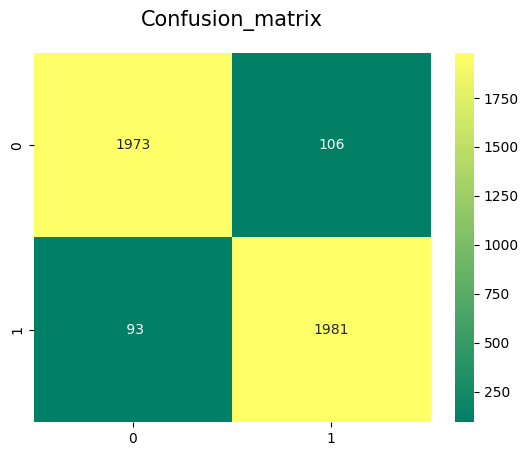

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

---
### **Test Accuracy: 0.9525644112689622**
---

## LighGBM Classifier model

In [ ]:
import lightgbm as lgb

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 20),
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'num_leaves': trial.suggest_int('num_leaves', 2, 20),
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1
    }

    model = lgb.LGBMClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-07-24 01:17:19,122] A new study created in memory with name: no-name-f319deea-e123-4563-965b-d83f11b88c1e
[I 2024-07-24 01:17:35,002] Trial 0 finished with value: 0.9649222685155264 and parameters: {'learning_rate': 0.09793341804000143, 'max_depth': 2, 'min_child_weight': 7.22358007151209, 'reg_lambda': 10.509457865428077, 'n_estimators': 89, 'num_leaves': 18}. Best is trial 0 with value: 0.9649222685155264.
[I 2024-07-24 01:17:49,452] Trial 1 finished with value: 0.9741219080138838 and parameters: {'learning_rate': 0.18173304368086554, 'max_depth': 2, 'min_child_weight': 9.27991245875921, 'reg_lambda': 10.28054842337497, 'n_estimators': 90, 'num_leaves': 11}. Best is trial 1 with value: 0.9741219080138838.
[I 2024-07-24 01:18:02,724] Trial 2 finished with value: 0.9415527833288255 and parameters: {'learning_rate': 0.013987033359546354, 'max_depth': 8, 'min_child_weight': 6.406671809224121, 'reg_lambda': 5.096660870804018, 'n_estimators': 32, 'num_leaves': 12}. Best is trial 1 

In [ ]:
print(f'Best parameters for LightGBM : {study.best_params}')

Best parameters for LightGBM : {'learning_rate': 0.18850547218658997, 'max_depth': 6, 'min_child_weight': 9.82028659116027, 'reg_lambda': 1.10111909055421, 'n_estimators': 190, 'num_leaves': 13}


In [ ]:
lgb_model = lgb.LGBMClassifier(**study.best_params, random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 8300, number of negative: 8308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 16608, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499759 -> initscore=-0.000963
[LightGBM] [Info] Start training from score -0.000963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(learning_rate=0.18850547218658997, max_depth=6,
               min_child_weight=9.82028659116027, n_estimators=190,
               num_leaves=13, random_state=42, reg_lambda=1.10111909055421)

In [ ]:
y_pred_test = lgb_model.predict(X_test)

### Model Evaluation

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'LightGBM - Test Accuracy: {test_accuracy}')
print(f'LightGBM - Test Precision: {test_precision}')
print(f'LightGBM - Test Recall: {test_recall}')
print(f'LightGBM - Test F1-score: {test_f1}')

LightGBM - Test Accuracy: 0.9542499398025523
LightGBM - Test Precision: 0.9507177033492823
LightGBM - Test Recall: 0.9580520732883318
LightGBM - Test F1-score: 0.9543707973102786


Text(0.5, 1.05, 'Confusion_matrix')

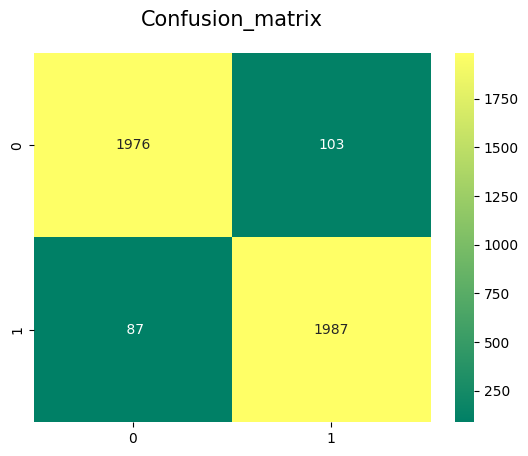

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

---
### **Test Accuracy: 0.9542499398025523**
---

# Create pipeline

In [ ]:
class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['title'].fillna('', inplace=True)
        X['author'].fillna('Unknown', inplace=True)
        X['combined_text'] = X['title'] + ' ' + X['author'] + ' ' + X['text']
        X.drop(columns=['id', 'title', 'author', 'text'], inplace=True)
        return X

## preprocessing_pipeline

In [ ]:
preprocessing_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer())
])

## feature_extraction_pipeline and dimensionality_reduction_pipeline

In [ ]:
feature_extraction_pipeline = ColumnTransformer([
    ('tfidf', TfidfVectorizer(token_pattern="[a-z']+", stop_words=list(STOPWORDS)), 'combined_text')
])

dimensionality_reduction_pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=500, algorithm='arpack'))
])

## transformation_pipeline

In [ ]:
transformation_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('features', feature_extraction_pipeline),
    ('dim_reduction', dimensionality_reduction_pipeline)
])

In [ ]:
filepath = "/content/drive/My Drive/Fake_news.csv"
df = pd.read_csv(filepath)

df = df.dropna(subset=['text'])
X = df.drop(columns='label')
y = df['label']

X_transformed = transformation_pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

## Define Model

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Model Evaluation

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'The Accuracy of the model is: {accuracy}')
print(f'The Precision of the model is: {precision}')
print(f'The Recall of the model is: {recall}')
print(f'The F1 score of the model is: {f1}')

The Accuracy of the model is: 0.9556946785456296
The Precision of the model is: 0.9470198675496688
The Recall of the model is: 0.9652844744455159
The F1 score of the model is: 0.9560649474689589


# Validate on the New data

In [ ]:
def predict_new_input(model, transformation_pipeline):
    id = input("Enter the id: ")
    title = input("Enter the title: ")
    author = input("Enter the author: ")
    text = input("Enter the text: ")

    new_data = pd.DataFrame({'id': [id], 'title': [title], 'author': [author], 'text': [text]})
    new_data_transformed = transformation_pipeline.transform(new_data)
    prediction = model.predict(new_data_transformed)

    return prediction[0]

new_prediction = predict_new_input(model, transformation_pipeline)
if new_prediction == 1:
    print('----------------------------------------------')
    print('The predicted label for the new input is: Fake')
else:
    print('----------------------------------------------')
    print('The predicted label for the new input is: Real')

Enter the id: 1
Enter the title: Chuck Todd: â€™BuzzFeed Did Donald Trump a Political Favorâ€™ - Breitbart
Enter the author: Jeff Poor
Enter the text: Wednesday after   Donald Trumpâ€™s press conference at Trump Tower in New York City, NBC â€œMeet the Pressâ€ moderator Chuck Todd expressed his exasperation over the normalcy of what he called a â€œcircusâ€ surrounding Trumpâ€™s event.  â€œI was struck big picture wise which is of how normal a circus is now to us,â€ Todd said. â€œThis was a circus. Weâ€™ve never seen a   a transition like we saw today where the press conference gets interrupted, you have a lawyer in here. The lawyer does half legal talk, half political spin. Iâ€™ve never seen that, using the lawyer to say heâ€™s here to make America great again, and by the way Iâ€™m going to play constitutional lawyer. I donâ€™t think this but clearly a constitutional lawyer told us we better not accept any of this money. So they made that exception. So I am struck at how normal crazy